In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# KubeFlow Pipelines :  HPO with AX - Pytorch Cifar10 Image classification

In this example, we train a Pytorch Lightning model to using image classification cifar10 dataset. A parent run will be created during the training process,which would dump the baseline model and relevant parameters,metrics and model along with its summary,subsequently followed by a set of nested child runs, which will dump the trial results. The best parameters would be dumped into the parent run once the experiments are completed.

This notebook shows PyTorch CIFAR10 end-to-end classification example using Kubeflow Pipelines. 

An example notebook that demonstrates how to:

* Get different tasks needed for the pipeline
* Create a Kubeflow pipeline
* Include Pytorch KFP components to preprocess, train, visualize and deploy the model in the pipeline
* Submit a job for execution
* Query(prediction and explain) the final deployed model


## import the necessary packages

In [1]:
! pip uninstall -y kfp
! pip install --no-cache-dir kfp ax-platform

In [2]:
import kfp
import json
import os
from kfp.onprem import use_k8s_secret
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url, func_to_container_op, InputPath
from kfp import dsl
from kfp import compiler

import numpy as np
import logging

from ax.service.ax_client import AxClient
import json

kfp.__version__

'1.6.4'

## Enter your gateway and the auth token
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)

![image.png](./image.png)

## Update values for the ingress gateway and auth session

In [3]:
INGRESS_GATEWAY='http://istio-ingressgateway.istio-system.svc.cluster.local'
AUTH="<auth-token>"  
NAMESPACE="kubeflow-user-example-com"
COOKIE="authservice_session="+AUTH
EXPERIMENT="Default"
dist_volume = 'dist-vol'
volume_mount_path ="/model"
results_path = volume_mount_path+"/results.json"

## Set  the Log bucket and Tensorboard Image

In [4]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="public.ecr.aws/pytorch-samples/tboard:latest"

## Set the client and create the experiment

In [5]:
client = kfp.Client(host=INGRESS_GATEWAY+"/pipeline", cookies=COOKIE)

In [6]:
client.create_experiment(EXPERIMENT)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 6, 21, 13, 13, 6, tzinfo=tzlocal()),
 'description': None,
 'id': 'ba9b7266-2b1c-4729-afcd-be808c25c5af',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Set  the Inference parameters

In [7]:
DEPLOY_NAME="torchserve"
MODEL_NAME="cifar10"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INPUT_REQUEST="https://raw.githubusercontent.com/kubeflow/pipelines/master/samples/contrib/pytorch-samples/cifar10/input.json"

## Load the the components yaml files for setting up the components

In [ ]:
! python utils/generate_templates.py cifar10/ax_template_mapping.json

In [12]:
prepare_tensorboard_op = load_component_from_file("yaml/tensorboard_component.yaml")

generate_trails_op = components.load_component_from_file(
    "yaml/ax_generate_trials_component.yaml"
)

complete_trails_op = components.load_component_from_file(
    "yaml/ax_complete_trials_component.yaml"
)

get_keys_op = components.load_component_from_file(
    "../../../components/json/Get_keys/component.yaml"
)

get_element_op = components.load_component_from_file(
    "../../../components/json/Get_element_by_key/component.yaml"
)
prep_op = components.load_component_from_file(
    "yaml/preprocess_component.yaml"
)

# Uncomment hpo inputs in component yaml
train_op = components.load_component_from_file(
    "yaml/ax_train_component.yaml"
)

deploy_op = load_component_from_file("yaml/deploy_component.yaml")

pred_op = load_component_from_file("yaml/prediction_component.yaml")

minio_op = components.load_component_from_file(
    "yaml/minio_component.yaml"
)

kubernetes_create_pvc_op = load_component_from_file("../../../components/kubernetes/Create_PersistentVolumeClaim/component.yaml")

In [ ]:
from kubernetes.client.models import V1Volume, V1PersistentVolumeClaimVolumeSource
def create_dist_pipeline():
    kubernetes_create_pvc_op(name=dist_volume, storage_size= "20Gi")

create_volume_run = client.create_run_from_pipeline_func(create_dist_pipeline, arguments={})
create_volume_run.wait_for_run_completion()

In [13]:
parameters = [
                {"name": "lr", "type": "range", "bounds": [1e-4, 0.2], "log_scale": True},
                {"name": "weight_decay", "type": "range", "bounds": [1e-4, 1e-2]},
                {"name": "eps", "type": "range", "bounds": [1e-8, 1e-2]},
             ]

## Define the pipeline

In [14]:
@dsl.pipeline(
    name="AX Hpo", description="Estimating best parameters using AX"
)
def pytorch_ax_hpo( # pylint: disable=too-many-arguments
    minio_endpoint=MINIO_ENDPOINT,
    log_bucket=LOG_BUCKET,
    log_dir=f"tensorboard/logs/{dsl.RUN_ID_PLACEHOLDER}",
    mar_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/model-store",
    config_prop_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/config",
    model_uri=f"s3://mlpipeline/mar/{dsl.RUN_ID_PLACEHOLDER}",
    best_params=f"hpo/{dsl.RUN_ID_PLACEHOLDER}",
    tf_image=TENSORBOARD_IMAGE,
    deploy=DEPLOY_NAME,
    isvc_name=ISVC_NAME,
    model=MODEL_NAME,
    namespace=NAMESPACE,
    confusion_matrix_log_dir=f"confusion_matrix/{dsl.RUN_ID_PLACEHOLDER}/",
    checkpoint_dir="checkpoint_dir/cifar10",
    input_req=INPUT_REQUEST,
    cookie=COOKIE,
    total_trials=2,
    ingress_gateway=INGRESS_GATEWAY,
):
   
    """This method defines the pipeline tasks and operations"""
    pod_template_spec = json.dumps({
        "spec": {
            "containers": [{
                "env": [
                    {
                        "name": "AWS_ACCESS_KEY_ID",
                        "valueFrom": {
                            "secretKeyRef": {
                                "name": "mlpipeline-minio-artifact",
                                "key": "accesskey",
                            }
                        },
                    },
                    {
                        "name": "AWS_SECRET_ACCESS_KEY",
                        "valueFrom": {
                            "secretKeyRef": {
                                "name": "mlpipeline-minio-artifact",
                                "key": "secretkey",
                            }
                        },
                    },
                    {
                        "name": "AWS_REGION",
                        "value": "minio"
                    },
                    {
                        "name": "S3_ENDPOINT",
                        "value": f"{minio_endpoint}",
                    },
                    {
                        "name": "S3_USE_HTTPS",
                        "value": "0"
                    },
                    {
                        "name": "S3_VERIFY_SSL",
                        "value": "0"
                    },
                ]
            }]
        }
    })

    prepare_tb_task = prepare_tensorboard_op(
        log_dir_uri=f"s3://{log_bucket}/{log_dir}",
        image=tf_image,
        pod_template_spec=pod_template_spec,
    ).set_display_name("Visualization")

    prep_task = (
        prep_op().after(prepare_tb_task).set_display_name("Preprocess & Transform")
    )

    gen_trials_task = generate_trails_op(total_trials, parameters, 'test-accuracy').after(prep_task).set_display_name("AX Generate Trials")
    
    get_keys_task = get_keys_op(gen_trials_task.outputs["trial_parameters"]).after(gen_trials_task).set_display_name("Get Keys of Trials")
    
    confusion_matrix_url = f"minio://{log_bucket}/{confusion_matrix_log_dir}"
    script_args = f"model_name=resnet.pth," \
                  f"confusion_matrix_url={confusion_matrix_url}"
    ptl_args = f"max_epochs=1, profiler=pytorch"

    with dsl.ParallelFor(get_keys_task.outputs["keys"]) as item:
        get_element_task = get_element_op(gen_trials_task.outputs["trial_parameters"], item).after(get_keys_task).set_display_name("Get Element from key")
        train_task = (
            train_op(
                trial_id=item,
                input_data=prep_task.outputs["output_data"],
                script_args=script_args,
                model_parameters=get_element_task.outputs["output"],
                ptl_arguments=ptl_args,
                results=results_path
            ).add_pvolumes({volume_mount_path: dsl.PipelineVolume(pvc=dist_volume)}).after(get_element_task).set_display_name("Training")
#             For GPU uncomment below line and set GPU limit and node selector
#             ).set_gpu_limit(1).add_node_selector_constraint('cloud.google.com/gke-accelerator','nvidia-tesla-p4')
        )
        
    complete_trials_task = complete_trails_op(gen_trials_task.outputs["client"], results_path).add_pvolumes({volume_mount_path: dsl.PipelineVolume(pvc=dist_volume)}).after(train_task).set_display_name("AX Complete Trials")

    dsl.get_pipeline_conf().add_op_transformer(
        use_k8s_secret(
            secret_name="mlpipeline-minio-artifact",
            k8s_secret_key_to_env={
                "secretkey": "MINIO_SECRET_KEY",
                "accesskey": "MINIO_ACCESS_KEY",
            },
        )
    )


## Compile  the pipeline

In [16]:
compiler.Compiler().compile(pytorch_ax_hpo, 'pytorch.tar.gz', type_check=True)

## Execute the pipeline

In [17]:
run = client.run_pipeline(my_experiment.id, 'pytorch_ax_hpo', 'pytorch.tar.gz')

## Viewing results

Wait for the pipeline execution to be completed. Sample pipeline shown below

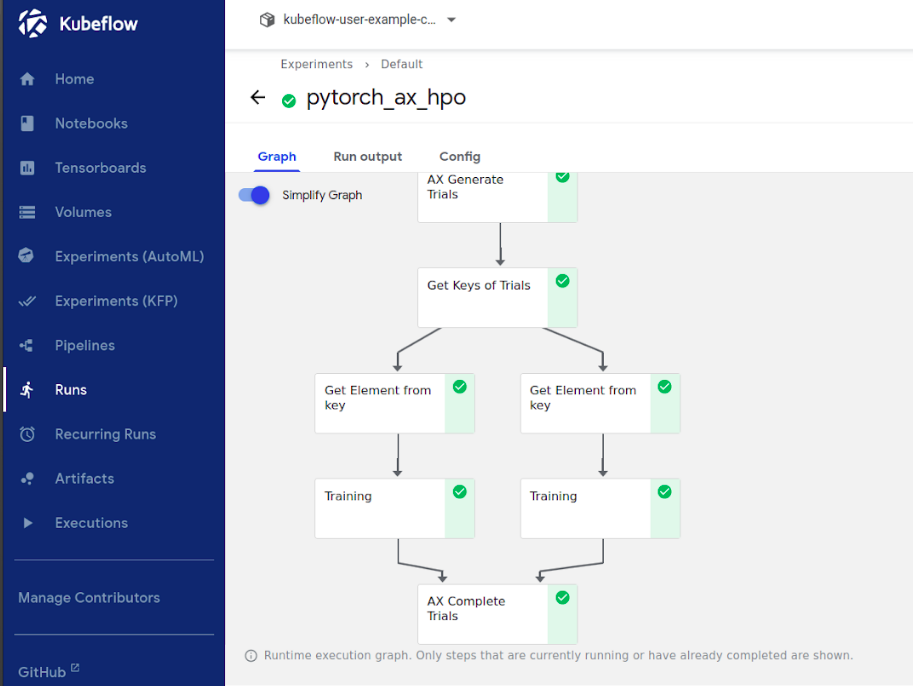

#### Click on "AX Complete Trials" component. The best hyperparameters are shown in the Input/Output tab as shown below

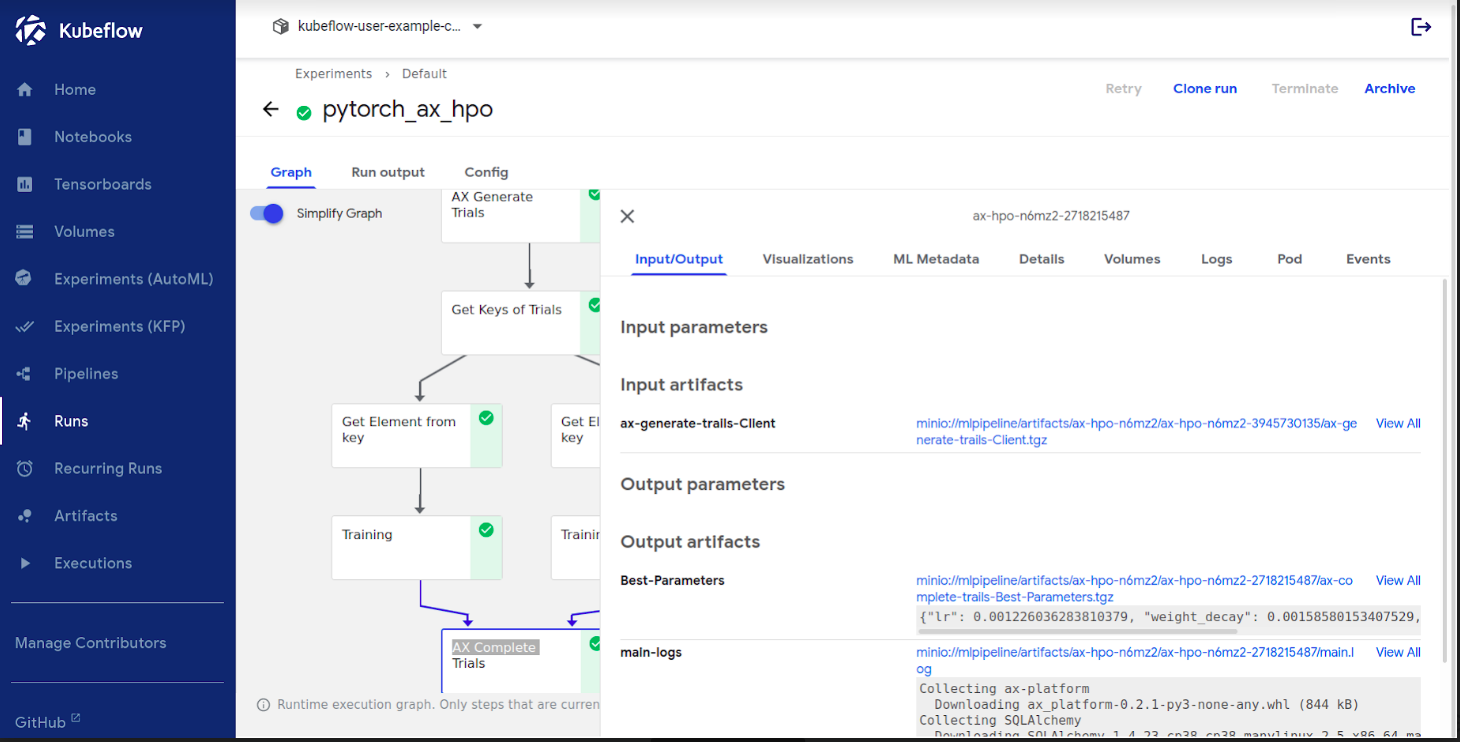

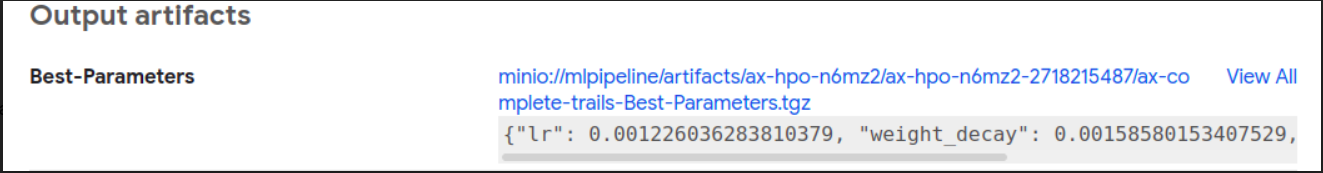